<a href="https://colab.research.google.com/github/regiiis/pv_error_classification/blob/main/pv_error_classifcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DLV Group Project - **Semantic Segmentation**

## Set up

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [54]:
# General imports
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import savetxt
from numpy import genfromtxt
import os, datetime
import sys
import math
import random

# Import graph plotting lib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Imoprt tensorflow and set to eager execution
import tensorflow as tf
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)

# Shortcuts to keras
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.utils import array_to_img
from IPython.display import Image

# Performance tools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
from PIL import Image as im
from skimage.transform import resize

In [3]:
# Import drive and allow access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Unzip data

!unzip "/content/drive/My Drive/Colab Notebooks/data/2020-02-14_InfraredSolarModules.zip"

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: InfraredSolarModules/images/2121.jpg  
  inflating: InfraredSolarModules/images/11778.jpg  
  inflating: InfraredSolarModules/images/5896.jpg  
  inflating: InfraredSolarModules/images/4550.jpg  
  inflating: InfraredSolarModules/images/19324.jpg  
  inflating: InfraredSolarModules/images/16017.jpg  
  inflating: InfraredSolarModules/images/10472.jpg  
  inflating: InfraredSolarModules/images/2135.jpg  
  inflating: InfraredSolarModules/images/4.jpg  
  inflating: InfraredSolarModules/images/5882.jpg  
  inflating: InfraredSolarModules/images/19330.jpg  
  inflating: InfraredSolarModules/images/4544.jpg  
  inflating: InfraredSolarModules/images/16003.jpg  
  inflating: InfraredSolarModules/images/12265.jpg  
  inflating: InfraredSolarModules/images/9060.jpg  
  inflating: InfraredSolarModules/images/14614.jpg  
  inflating: InfraredSolarModules/images/6353.jpg  
  inflating: InfraredSolarModules/images/970

In [5]:
# Load data into df

df = pd.read_json("/content/InfraredSolarModules/module_metadata.json",orient="index")
df['image_name'] = df['image_filepath'].str[7:]
df = df.sort_index()
df

,image_filepath,anomaly_class,image_name
0,images/0.jpg,Offline-Module,0.jpg
1,images/1.jpg,Offline-Module,1.jpg
2,images/2.jpg,Offline-Module,2.jpg
3,images/3.jpg,Offline-Module,3.jpg
4,images/4.jpg,Offline-Module,4.jpg
...,...,...,...
19995,images/19995.jpg,No-Anomaly,19995.jpg
19996,images/19996.jpg,No-Anomaly,19996.jpg
19997,images/19997.jpg,No-Anomaly,19997.jpg
19998,images/19998.jpg,No-Anomaly,19998.jpg


## Explore Data

In [9]:
# Display all categories

categories = df["anomaly_class"].unique()
list(categories)

['Offline-Module',
 'Diode-Multi',
 'Diode',
 'Shadowing',
 'Cell-Multi',
 'Cell',
 'Hot-Spot',
 'Cracking',
 'Hot-Spot-Multi',
 'Soiling',
 'Vegetation',
 'No-Anomaly']

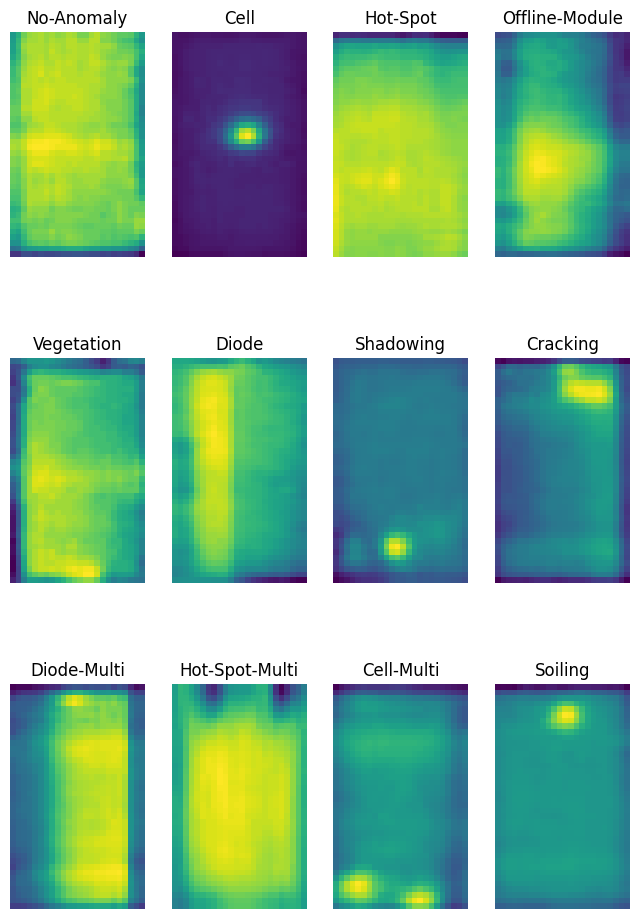

In [119]:
# Select and display a iamge for each category

df.groupby('anomaly_class').head(1)
img1 = mpimg.imread('/content/InfraredSolarModules/images/13357.jpg') #No-Anomaly
img2 = mpimg.imread('/content/InfraredSolarModules/images/5988.jpg')  #Cell
img3 = mpimg.imread('/content/InfraredSolarModules/images/6796.jpg')  #Hot-Spot
img4 = mpimg.imread('/content/InfraredSolarModules/images/270.jpg')  #Offline-Module
img5 = mpimg.imread('/content/InfraredSolarModules/images/9528.jpg') #Vegetation
img6 = mpimg.imread('/content/InfraredSolarModules/images/2143.jpg')  #Diode
img7 = mpimg.imread('/content/InfraredSolarModules/images/3519.jpg')  #Shadowing
img8 = mpimg.imread('/content/InfraredSolarModules/images/7188.jpg')  #Cracking
img9 = mpimg.imread('/content/InfraredSolarModules/images/876.jpg') #Diode-Multi
img10 = mpimg.imread('/content/InfraredSolarModules/images/8019.jpg')  #Hot-Spot-Multi
img11 = mpimg.imread('/content/InfraredSolarModules/images/4592.jpg')  #Cell-Multi
img12 = mpimg.imread('/content/InfraredSolarModules/images/8291.jpg')  #Soiling

#create list of image name
list_img = []
for i in range(12):
  list_img.append(f"img{i+1}")

# Create list of category names
list_categories = ['No-Anomaly','Cell','Hot-Spot','Offline-Module','Vegetation','Diode','Shadowing',
            'Cracking','Diode-Multi','Hot-Spot-Multi','Cell-Multi','Soiling']

# Plot images
fig = plt.figure(figsize=(8, 12))
columns = 4
rows = 3
for i,n in zip(range(1, columns*rows +1), list_categories):
    img = f"img{i}"
    fig.add_subplot(rows, columns, i)
    plt.imshow(globals()[img])
    plt.title(n)
    plt.axis('off')
plt.show()



In [118]:
# Summary Statistics

df["anomaly_class"].describe()

count          20000
unique            12
top       No-Anomaly
freq           10000
Name: anomaly_class, dtype: object


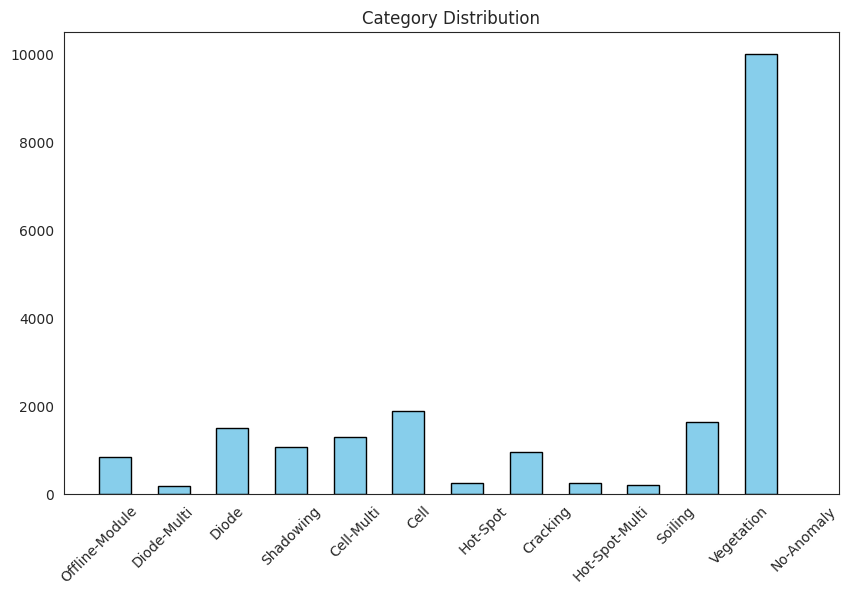

In [175]:
from IPython.core.pylabtools import figsize
import seaborn as sns
sns.set_style("white")

figsize(10, 6)
plt.hist(df["anomaly_class"], color='skyblue', edgecolor='black', bins = 12, width = 0.5, rwidth = 1)
plt.title('Category Distribution')
plt.xticks(rotation = 45)

plt.show()

## Data Preparation

### Create train, validation and test df

In [140]:
# Split data into df with 0.8/0.1/0.1 ratio

reduced_df = df.sample(frac = 1, random_state = 200) # random -> seed value
train_df = reduced_df.sample(frac = 0.8,random_state = 200)
validation_test_df = reduced_df.drop(train_df.index)
validation_df = validation_test_df.sample(frac = 0.5,random_state = 200)

test_df=validation_test_df.drop(validation_df.index)

print(train_df.info())
print(validation_df.info())

test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 6173 to 19483
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  16000 non-null  object
 1   anomaly_class   16000 non-null  object
 2   image_name      16000 non-null  object
dtypes: object(3)
memory usage: 500.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 11758 to 6277
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  2000 non-null   object
 1   anomaly_class   2000 non-null   object
 2   image_name      2000 non-null   object
dtypes: object(3)
memory usage: 62.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 8571 to 11343
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  2000 non-null   object
 1  

In [144]:
# Set up train, validation and test generator

image_height = 40
image_width = 24
batch_size = 32
datagen_train=ImageDataGenerator(rescale=1./255)
datagen_validation=ImageDataGenerator(rescale=1./255)


train_generator = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory = "/content/InfraredSolarModules/images/",
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    batch_size = batch_size,
    color_mode = "grayscale"
    shuffle = False
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe = validation_df,
    directory = "/content/InfraredSolarModules/images/",
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    batch_size = batch_size,
    color_mode = "grayscale"
    shuffle = False
)

test_generator = datagen_validation.flow_from_dataframe(
    dataframe = test_df,
    directory = "/content/InfraredSolarModules/images/",
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    batch_size = batch_size,
    color_mode = "grayscale"
    shuffle = False
)


Found 16000 validated image filenames belonging to 12 classes.
Found 2000 validated image filenames belonging to 12 classes.
Found 2000 validated image filenames belonging to 12 classes.


# CNN Model

## Build Model

In [145]:
# Build CNN model

image_height = 40
image_width = 24
num_classes = 12

model_0 = Sequential()
model_0.add(Conv2D(filters = 32, kernel_size=(3,3), input_shape=(image_height, image_width, 1)))
model_0.add(Activation('relu'))
model_0.add(MaxPooling2D(pool_size= (2,2)))

model_0.add(Conv2D(filters = 64, kernel_size=(3,3)))
model_0.add(Activation('relu'))
model_0.add(MaxPooling2D(pool_size = (2,2)))

model_0.add(Conv2D(filters = 128, kernel_size=(3,3)))
model_0.add(Activation('relu'))
model_0.add(MaxPooling2D(pool_size = (2,2)))

model_0.add(Flatten())
model_0.add(Dense(num_classes))
model_0.add(Activation('softmax'))

model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-3),
              metrics=['accuracy'])
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 22, 32)        320       
                                                                 
 activation (Activation)     (None, 38, 22, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 19, 11, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 9, 64)         18496     
                                                                 
 activation_1 (Activation)   (None, 17, 9, 64)         0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 4, 64)          0         
 g2D)                                                   

## Train Model

In [147]:
history_0 = model_0.fit(
    train_generator,
    epochs = 20,
    validation_data = validation_generator
 )

#model_0.save("/content/drive/MyDrive/model_0")

Epoch 1/20
500/500 [==============================] - 29s 59ms/step - loss: 1.4835 - accuracy: 0.5604 - val_loss: 1.4290 - val_accuracy: 0.5715
Epoch 2/20
500/500 [==============================] - 36s 73ms/step - loss: 1.3530 - accuracy: 0.5981 - val_loss: 1.3267 - val_accuracy: 0.6010
Epoch 3/20
500/500 [==============================] - 21s 41ms/step - loss: 1.2650 - accuracy: 0.6204 - val_loss: 1.2476 - val_accuracy: 0.6265
Epoch 4/20
500/500 [==============================] - 25s 49ms/step - loss: 1.2088 - accuracy: 0.6374 - val_loss: 1.2053 - val_accuracy: 0.6350
Epoch 5/20
500/500 [==============================] - 25s 51ms/step - loss: 1.1660 - accuracy: 0.6486 - val_loss: 1.2759 - val_accuracy: 0.6360
Epoch 6/20
500/500 [==============================] - 28s 56ms/step - loss: 1.1277 - accuracy: 0.6539 - val_loss: 1.1790 - val_accuracy: 0.6490
Epoch 7/20
500/500 [==============================] - 29s 58ms/step - loss: 1.0977 - accuracy: 0.6614 - val_loss: 1.1275 - val_accuracy:

## Model Training Performance

<ipython-input-169-ffa7f4e04e01>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_accuracy, "b", label = "Validation accuracy",color = "orange")
<ipython-input-169-ffa7f4e04e01>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, "b", label="Validation loss",color = "orange")


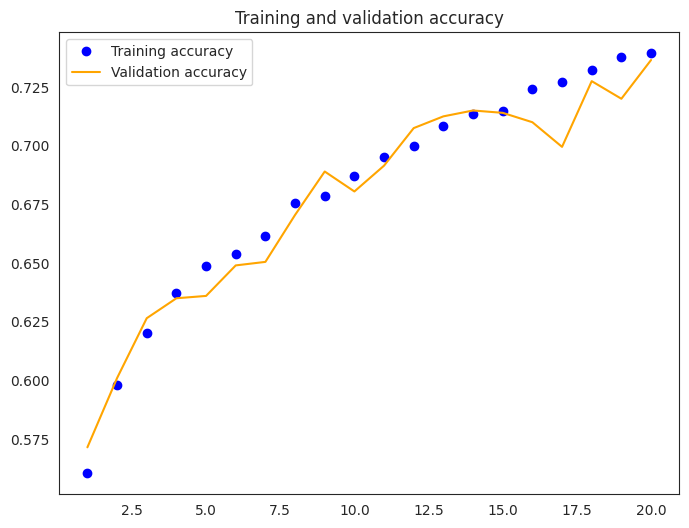

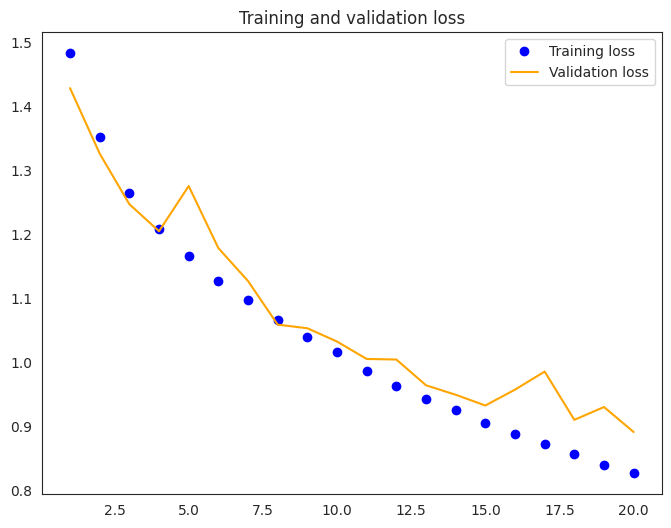

In [169]:
plt.figure(figsize = (8,6))
accuracy = history_0.history["accuracy"]
val_accuracy = history_0.history["val_accuracy"]
loss = history_0.history["loss"]
val_loss = history_0.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label = "Training accuracy")
plt.plot(epochs, val_accuracy, "b", label = "Validation accuracy",color = "orange")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize = (8,6))
plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss", color = "orange")
plt.title("Training and validation loss")
plt.legend()

plt.show()

## Confusion Matrix

In [165]:
x = list(train_generator.class_indices.keys())
num_of_test_samples = 2000

Y_pred = model_0.predict_generator(test_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print()
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

print()
print('Classification Report')
target_names = x
print(classification_report(test_generator.classes, y_pred, target_names = target_names))


<ipython-input-165-369cb1ad24b4>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model_0.predict_generator(test_generator, num_of_test_samples // batch_size+1)



Confusion Matrix
[[ 16   6   9  11   1   1   5 109   3   7   0  14]
 [ 10   4   7   7   3   1   1  86   4   3   0  15]
 [  8   5   4   4   0   1   0  56   2   0   1   4]
 [ 11   6   7   9   1   2   2  91   4   4   1  11]
 [  0   1   0   2   0   0   0  12   0   2   0   1]
 [  1   3   0   2   1   0   1  15   0   1   0   1]
 [  1   1   3   1   0   0   0  19   0   0   0   1]
 [ 85  25  51  76   9   3   7 603  35  35   4  84]
 [  4   4   5  11   1   0   1  52   2   6   0   7]
 [  7   6   3   7   1   1   0  61   3   5   0   4]
 [  2   0   1   2   0   0   0   7   0   1   0   2]
 [ 13   2   8  16   0   0   0  90   6   8   0   8]]

Classification Report
                precision    recall  f1-score   support

          Cell       0.10      0.09      0.09       182
    Cell-Multi       0.06      0.03      0.04       141
      Cracking       0.04      0.05      0.04        85
         Diode       0.06      0.06      0.06       149
   Diode-Multi       0.00      0.00      0.00        18
      Hot

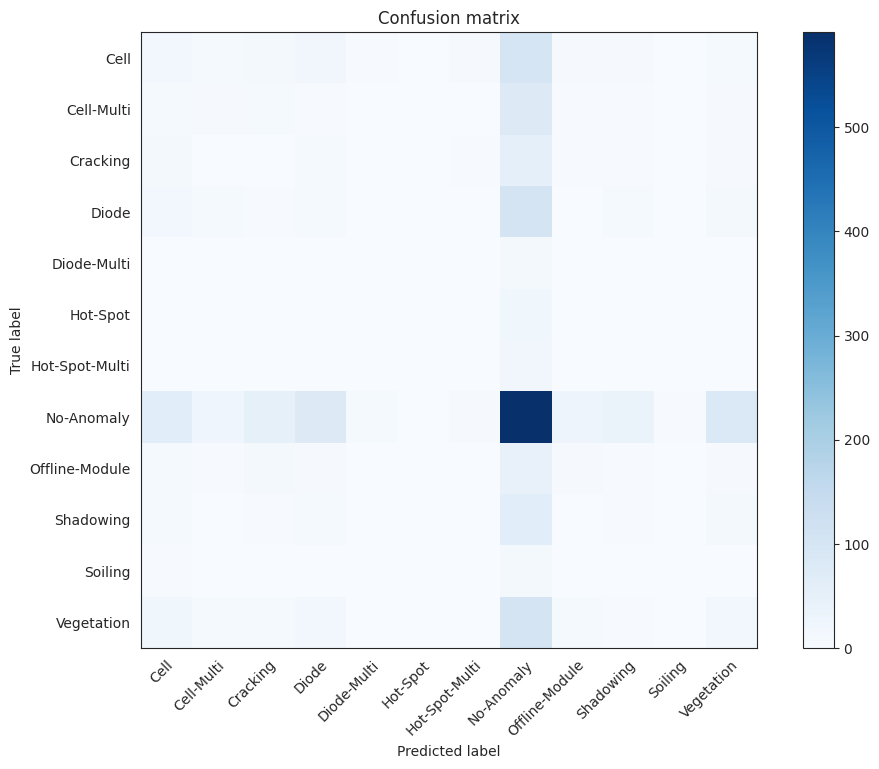

In [167]:
cm = confusion_matrix(validation_generator.classes, y_pred)
fig, ax = plt.subplots(figsize = (12,8))
im = ax.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
title = 'Confusion matrix'
ax.figure.colorbar(im, ax = ax)
ax.set(xticks = np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels = target_names, yticklabels = target_names,
    title=title,
    ylabel ='True label',
    xlabel ='Predicted label',
    )
plt.setp(ax.get_xticklabels(), rotation=45, ha = "right",
             rotation_mode = "anchor")
np.set_printoptions(precision = 2)
plt.show()

In [170]:
model_0.evaluate(test_generator)

63/63 [==============================] - 2s 33ms/step - loss: 0.8958 - accuracy: 0.7305


[0.895754337310791, 0.7304999828338623]